# PHYS 240: Final Project
## Jackson Sheppard

In [5]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Theory
## Molecular Dynamics and the Weighted Histogram Analysis Method

Here we present a literature study of "BayesWHAM: A Bayesian Approach for Free Eenergy Estimation, Reweighting,
and Uncertainty Quantification in the Weighted Histogram Analysis Method", by Andrew L. Ferguson. The original
work can be accessed through [onlinelibrary.wiley.com](https://onlinelibrary.wiley.com/doi/10.1002/jcc.24800)
with the original codebase and associated documentation available through
[BitBucket](https://bitbucket.org/andrewlferguson/bayeswham_python/src/master/). Updated code for the purposes of
this analysis can be accessed through [GitHub](https://github.com/jsheppard95/bayeswham_python).

The Weighted Histogram Analysis Method (WHAM) is a technique to estimate free energy surfaces of molecular system
simulated using Molecular Dynamics (MD), a simulation technique involving the numerical integration of Newton's
second law for a collection of particles, tracking particle positions and velocities at each time step to yield
a molecular trajectory. One can then calculate thermodynamic properties as time averages over the trajectory.

MD simulations are performed using thermodynamic ensembles. Examples include the canonical $NVT$ ensemble
(constant number of particles $N$, volume $V$, and temperature $T$) and the isothermal-isobaric $NPT$ ensemble
(where now the pressure $P$ is held constant in adddition to $N$ and $T$). These simulation ensembles have
corresponding distributions of microstates given by Boltzmann factors, e.g for the canonical ensemble:

\begin{equation}
\label{eq:1}
P(\underline{r}^N) = \frac{e^{-\beta U(\underline{r}^N)}}{Z}
\end{equation}

Where a given microstate is defined by the $3N$ dimension vector $\underline{r}^N$ ($N$ particles, each defined by
three coordinates), $\beta = 1/k_BT$ is the inverse temperature (where $k_B$ is Boltzmann's constant), and
$Z = \int d\underline{r}^N e^{-\beta U(\underline{r}^N)}$ is the partition function for the canonical ensemble
that also serves as the normalization constant for the distribution defined in equation \ref{eq:1}.
$U(\underline{r}^N)$ then defines a potential energy surface (PES), but due to it's high dimensionality
($N \approx 10^3$ for typical simulations), this quantity can be difficult to interpret. Instead, a free energy
surface (FES) is defined in terms of a set of $m < 3N$ collective order parameters $\underline{\psi}$ that serve
as a low-dimensional projection of the PES, mapping multiple configurations to the same collective coordinates.
This projection is achived through the dirac delta function that picks out configurations with a given value of
$\underline{\psi}$:

\begin{equation}
\label{eq:2}
P(\underline{\psi}) = \int{P(\underline{r}^N) \delta ( \underline{\psi} ( \underline{r}^N )- \underline{\psi})}d\underline{r}^N
\end{equation}

And for the canonical ensemble:

\begin{equation}
\label{eq:3}
P(\underline{\psi}) = \frac{1}{Z} \int{ e^{-\beta U(\underline{r}^N)} \delta ( \underline{\psi} ( \underline{r}^N )- \underline{\psi})}d\underline{r}^N
\end{equation}

The free energy surface (FES) is then defined in terms of the collective order parameters as:

\begin{equation}
\label{eq:F}
F(\underline{\psi}) = -k_BT\ln{(P(\underline{\psi}))}
\end{equation}

The collective order parameters can then be determined using dimensionality reduction methods such as principal
component analysis, or by considering specific parameters relevant to the physics of the system of interest, e.g
the dihedral bond angles $\phi$ and $\psi$ of the molecular system.

The reduction of the PES to the lower dimensional FES is still insufficient to overcome high potential energy
barriers typical of molecular systems, and thus unbiased MD simulations would not allow for an extensive search
of the $\underline{\psi}$ parameter space. As a remedy, a technique known as umbrella sampling is employed. This
process includes biasing the potential energy with typically harmonic restraining potentials of changing center
locations $\underline{\psi_i}$.

\begin{equation}
w_i( \underline{ \psi }( \underline{r}^N ); \textbf{ K }_i, \underline{\psi_i}) = \frac{1}{2}(\underline{ \psi }( \underline{r}^N ) - \underline{\psi_i}))^T \textbf{ K }_i (\underline{ \psi }( \underline{r}^N ) - \underline{\psi_i}))
\end{equation}

Here $\textbf{K}_i$ is an $m$-by-$m$ diagonal matrix of force constants in each dimension of $\psi$. One can then
perform repeated simulations with changing center locations to complete a reaonsable exploration of parameter
space in the viscinity of each $\psi_i$. Ferguson then shows then one can determine an estimate for the unbiased
distribution of microstates in terms of the collective order parameters from the biased simulation $i$ through
the following relationship:

\begin{equation}
\label{WHAM_est}
\hat{P}_i(\underline{\psi}) = \frac{n_i(\underline{\psi})}{N_i c_i(\underline{\psi})f_i}
\end{equation}

where $n_i(\underline{\psi})$ is the number density of observation of the system over the course of the biased
simulation $i$ in a differential volume element $d\underline{\psi}$, $N_i$ is the total number of observations
extracted in the simulation trajectory, $c_i(\underline{\psi}) = e^{-\beta w_i}$ is the Boltzmann factor of the
bias potential, and $f_i = Z/Z_i^B$ is the ratio of partitition functions of the unbiased
system and the biased system. The free energy is then related to the partition function by $-\beta F = \ln{Z}$,
so we can write this ratio as $f_i = e^{-\beta(F - F_i^B)}$ making it clear that this is the shift in free energy
between the biased and unbiased systems.

We thus have an estimate of the unbiased FES by application of equation \ref{eq:F}, i.e

\begin{equation}
\hat{F}_i(\underline{\psi}) = -k_BT\ln{\hat{P}_i(\underline{\psi})}
\end{equation}

## Bayesian Approach to WHAM

It is thus clear that a typical umbrella sampling data set for which a WHAM analysis method could be employed
would include a series of MD simulations indexed $i=1,...S$, each with a different bias potential $w_i$, and
corresponding trajectories of collective order parameters $\underline{\psi}$. One can then view equation
\ref{WHAM_est} as a relationship between the biased distribution $p_{i,l}^B = n_{i,l}/N_i$ (we now include index
$l$ to distinguish from the simulation index $i$, where $l$ is now a bin number of the $\underline{\psi}$
coordinates discretized into $M$ bins, i.e $l=1,..., M$) and the unbiased distribution $\hat{p}_{i,l}$:

\begin{equation}
\label{eq:unbias-est}
\hat{p}_{i,l} = \frac{p_{i,l}^B}{c_{i,l}f_i}
\end{equation}

where we now consider $c_{i,l}$ as the Boltzmann factor of the bias potential in bin $l$ of simulation $i$. The
Bayesian approach to this problem is then to find the best unbiased distribution $\{p_l\}$ (the model) given our
biased simulation bin counts $\{n_{i,l}\}$ (the data). This inverts equation \ref{eq:unbias-est} to be viewed as
a relationship between the true unbiased distribution $\{ p_l \}$ and a corresponding predicted biased
distribution $\hat{p}_{i,l}^B$:

\begin{equation}
\label{eq:13}
\hat{p}_{i,l}^B = p_lc_{i,l}f_i
\end{equation}

We thus proceed using Bayes' Theorem:

\begin{equation}
\label{eq:15}
P(\{ p_l \}|\{ n_{i,l} \} ) = \frac{P(\{ n_{i,l} \}|\{ p_l \})P(\{ p_l \})}{P(\{ n_{i,l} \})}
\end{equation}

$P(\{ p_l \}|\{ n_{i,l} \} )$ is referred to as the posterior probability of the unbiased distribution
$\{ p_l \}$ given the data $\{ n_{i,l} \}$, $P(\{ n_{i,l} \}|\{ p_l \})$ is the probability of the data given the
model (the likelihood), $P(\{ p_l \})$ is the prior probability of our model before observing data, and
$P(\{ n_{i,l} \})$ is the probability of observing our particular data set. $P(\{ n_{i,l} \})$ is referred to as
the evidence but can be interpreted as a normalization factor of the posterior, i.e
$P(\{ n_{i,l} \}) = \int{P(\{ n_{i,l} \}|\{ p_l \})P(\{ p_l \})}d\{ p_l \}$. We then determine our best model
by maximization of this posterior distribution. We thus see that a uniform prior
($P(\{ p_l \})$ = C), would cancel through this normalization, and the posterior distribution would be the same
as the normalized likelihood, and thus a maximum posterior estimate of the unbiased distribution would be the
same as a maximum likelihood estimate. This however does not need to be the case, and Ferguson instead develops
maximum posterior estimates for arbitrary priors.

The task is now to express the likelihood function of observing the data (biased bin counts) given the true
unbiased distribution $\{ p_l \}$. Ferguson does so by considering the likelihood for a single simulation $i$ as
a multinomial distribution, i.e:

\begin{equation}
\mathcal{L}_i = P_i(n_{i,1}, n_{i,2}, ..., n_{i,M}|\{p_l\}) = \frac{N_i!}{\prod_{l=1}^Mn_{i,l}!}\prod_{l=1}^M (\hat{p}_{i,l}^B)^{p_{i,l}^BN_i} = \frac{(\sum_{l=1}^M n_{i,l})!}{\prod_{l=1}^Mn_{i,l}!}\prod_{l=1}^M (p_lc_{i,l}f_i)^{n_{i,l}}
\end{equation}

where the last equality follows from equation \ref{eq:13} and the fact that $N_i = \sum_{l=1}^M n_{i,l}$.
Assuming each biased simulation is independent, the total likelihood is then given by the product over the $S$
simulations of the individual likelihoods $\mathcal{L}_i$. Ferguson simplifies this expression and finds:

\begin{equation}
\mathcal{L} = P(\{ n_{i,l} \}|\{ p_l \}) = D(\{ n_{i,l} \},\{ c_{i,l} \}) \prod_{l=1}^M p_l^{M_l} \prod_{i = 1}^S \bigg( \sum_{l=1}^M p_l c_{i,l} \bigg)^{-N_i}
\end{equation}

where $D(\{ n_{i,l} \},\{ c_{i,l} \})$ is a multiplicative factor that importantly does not depend on the desired
unbiased distribution $p_{l}$, $N_i = \sum_{l=1}^M n_{i, l}$ is the total number of observations in simulation
$i$ aggregated over all $M$ bins, and $M_l = \sum_{i=1}^S n_{i, 1}$ is the total number of observations in bin
$l$ aggregated over all $S$ simulations.

## Maximum Posterior/Maximum Likelihood Estimates of the Unbiased FES

Equipped with the likelihood function, Ferguson develops a best estimate for the true unbiased distribution by
maximization of the posterior distribution defined in equation \ref{eq:15}. As stated previously, this is
equivalent to maximizing the likelihood function itself in the case of a uniform prior, but Ferguson performs
this maximization for arbitrary priors using the method of Langrange multipliers. This yields the following
estimate of the distribution of unbiased counts $\{ p_l \}^{MAP}$:

\begin{equation}
\label{eq:25}
p_k = \frac{M_k + p_k\frac{\partial\ln{P(\{ p_l \})}}{\partial p_k}|_{p_{l \neq k}}}{\sum_{i=1}^S N_ic_{i,k}f_i + \sum_{k=1}^M p_k\frac{\partial\ln{P(\{ p_l \})}}{\partial p_k}|_{p_{l \neq k}}}, \quad k=1...M
\end{equation}

\begin{equation}
\label{eq:26}
f_i^{-1} = \sum_{l=1}^Mp_lc_{i,l}, \quad i=1...S
\end{equation}

where equation \ref{eq:26} follows from normalization of the biased distribution of bin counts. This then leads
to a best estimate of the unbiased FES over the discretized collective coordinates, $\{ F_l \}^{MAP}$:

\begin{equation}
F_k = -k_BT\ln{\big( \frac{p_k^{MAP}}{V_k} \big)} + C, \quad k=1...M
\end{equation}

where $V_k$ is the volume of bin $k$ in the collective parameters and C is an arbitrary constant corresponding
to the fact that only energy differences are meaningful. Given a data set of umbrella sampled MD simulations,
one can then solve equation \ref{eq:25} for the distribution of unbiased counts by iteration of $p_k$ until
self-consistency is achieved. We note however that in the case of a uniform prior where the maximum posterior
distribution estimate is equivalent to the maximum likelihood estimate and
$\partial \ln{P(\{ p_l \})}/\partial p_k = 0$, equation \ref{eq:25} reduces to that for $\{p_l\}^{ML}$:

\begin{equation}
p_k = \frac{M_k}{\sum_{i=1}^S N_ic_{i,k}f_i}, \quad k=1...M
\end{equation}

Thus for a uniform prior, no iteration is necessary and the unbiased distribution can simply be calculated
from the biased data set. Ferguson then describes the iterative process to solve equation \ref{eq:25} for an
arbitrary prior in Algorithm $1$ of his work, summarized below in a Pythonic formulation:

```
def BayesWHAM(data, bias_boltz_fact, prior, tol):
    """
    data : {n_{i, l}}, Biased simulation counts
    bias_boltz_fact : {c_{i, l}}, Bias potential boltzmann fatcors
    prior : functional form of the prior distribution
    tol : self-consistency tolerance
    """
    # Initialization
    M_k = np.sum(data[i])  # Sum over i, do so for k = 1...M
    N_i = np.sum(data[k])  # Sum over k (= l), do so for i = 1...S
    p_k = 1/M  # k = 1...M, initial guess for unbiased distribution = uniform
    f_i = np.sum(p_k * bias_boltz_fact[k])**-1  # Sum over k (= l), do so for i = 1...S
    dp_max = float("Inf")  # Large value for initial deviation from self-consistency
    
    while dp_max > tol:
        # Save the old distribution
        p_k_old = p_k
        # If uniform prior, no need to iterate, just solve for the best distribution 
        if prior = None:
            p_k = M_k/np.sum(N_i * bias_boltz_fact[i] * f_i)  # Sum over i, do so for k = 1...M
        else:
            # Otherwise we need to iterate by applying the BayesWHAM equation
            dp_max_inner = float("Inf")
            p_k_inner = p_k
            while dp_max_inner > tol:
                p_k_inner_old = p_k_inner
                p_k_inner = BayesWHAM(p_k_inner)
                dp_max_inner = max(p_k_inner - p_k_inner_old)  # max over k
            p_k = p_k_inner
        # Renormalize the distribution
        p_k = p_k/np.sum(p_k)
        # Recalculate f_i
        f_i = np.sum(p_k * bias_boltz_fact[k])  # Sum over k (= l), do so for i = 1...S
        # Recalculate dp_max
        dp_max = max(p_k - p_k_old)  # max over k

    return p_k
```

## Uncertainty Quantification by Markov Chain Monte Carlo
Ferguson continues his analysis to formulate a routine to calculate the uncertainty in the FES predicted by
maximization of the posterior distribution using the Metropolis-Hastings (MH) implementation of Markov Chain
Monte Carlo (MCMC), in which a sequence of realizations of the unbiased distribution $\{p_l\}$ is generated as a
Markov Chain for which statistics can be calculated from. These realizations are condisered samples of the true
posterior distribution. Enforcing that one accept/reject proposal moves in the distribution of $\{p_l\}$
according to the rule of detailed balance, Ferguson derives the following acceptence criterion for the random
walk in $\{p_l\}$-space employed by the Metropolis-Hastings algorithm:

\begin{equation}
\label{eq:44}
\alpha(\{p_l\}^\nu|\{p_l\}^\mu) = \text{min}\bigg[ \exp{\big( \sum_{l=1}^M M_l\ln{(\frac{p_l^\nu}{p_l^\mu})} + \sum_{i=1}^SN_i\ln{(\frac{f_i^\nu}{f_i^\mu})} + \ln{(\frac{P(\{p_l\}^\nu)}{P(\{p_l\}^\mu)})} \big)}, 1 \bigg]
\end{equation}

where $\nu$ is the proposed state and $\mu$ is the current state of the random walk. We again note that the last
term of exponential in equation \ref{eq:44} vanishes in the case of a uniform prior. Given this acceptance
criteria, one can generate a series of unbiased distributions $\{p_{l,q}\}^{MH}$, where the index $q$ now
indicates the MCMC step number. One can then determine a sequence of free energy curves $\{F_{l,q}\}^{MH}$, each
generated from a different sample of the true posterior distribution of unbiased counts:

\begin{equation}
\label{eq:48}
F_{k, q} = -k_BT\ln{\big( \frac{p_k^{MH}}{V_k} \big)} + C_q, \quad k=1...M
\end{equation}

Having expressed the acceptence criterion in terms of biased trajectory parameters and the unbiased distribution
at the current and proposed Markov Chain steps, Ferguson describes a procedure to store the posterior sampled
distributions in Algorithm $2$ of his work, again reformulated as Pythonic pseudo-code:

```
def BayesMH(data, bias_boltz_fact, prior, guess, nMCMC, dp)
    """
    data : {n_{i, l}}, Biased simulation counts
    bias_boltz_fact : {c_{i, l}}, Bias potential boltzmann fatcors
    prior : functional form of the prior distribution
    guess : initial guess for unbiased distribution -> maximum posterior result p_k^MAP
    nMCMC : number of Markov Chain Monte Carlo steps to conduct
    dp : maximum proposal step size
    """
    # Initialization
    M_k = np.sum(data[i])  # Sum over i, do so for k = 1...M
    N_i = np.sum(data[k])  # Sum over k (= l), do so for i = 1...S
    p_k = guess  # k = 1...M, initial guess for unbiased distribution = uniform
    f_i = np.sum(p_k * bias_boltz_fact[k])**-1  # Sum over k (= l), do so for i = 1...S
    
    p_k_MH = np.zeros(nMCMC)
    for q in range(nMCMC):
        # Save the current state
        p_k_prime = p_k
        f_i_prime = f_i
        # Select a random bin to maintain symmetry required for detailed balance
        bin = np.randint(1, M)
        # Symmetric random walk trial move:
        p_k[bin] = p_k[bin] + (2*np.rand(0, 1) - 0.5)*dp
        # Renormalize the resulting distribution
        p_k = p_k/np.sum(p_k)
        # Update f_i
        f_i = np.sum(p_k * bias_boltz_fact[k])**-1
        # Calculate likelihood ratio:
        r = AcceptanceCriterionExp(p_k, p_k_prime, f_i, f_i_prime, prior(p_k), prior(p_k_prime))
        if randFloat(0, 1) > r:
            # Reject move and revert to the previous state
            p_k = p_k_prime
            f_i = f_i_prime
        # Store updated chain
        p_k_MH[q] = p_k
        return p_k_MH
```

This algorithm results in a two dimensional array $\{p_{l, q}\}^{MH}$ holding the unbiased distribution of counts
in bin $l$ of the discretized collective parameters for step $q$ of the Markov Chain, and equation \ref{eq:48}
gives the resulting free energy surfaces sampled from the the posterior distribution of these surfaces. We
visualize the progression of this chain by plotting the log of the sampled posterior distribution (log likelihood
in the case of a uniform prior) versus the its MCMC step. After discarding the burn-in time, this value will
fluctuate about a steady value, at which point the sampled posterior distribution has converged to the true
posterior. One can then compute correlation lengths and infer uncertainties from the statistics of this resulting
distribution.

Finally, in order to visually compare the FES pedicted by a single maximum posterior estimate and the
distribution of those predicted by MCMC, the additive constants $C$ and $C_q$ need to be set such that the
landscapes predicted by each method are aligned. Ferguson does this by setting each additive constant such that
it's corresponding FES has zero mean, i.e:

\begin{equation}
C: \quad \sum_{l = 1}^M F_l^{MAP} = 0, \qquad C_q: \quad \sum_{l = 1}^M F_{l, q}^{MH} = 0
\end{equation}

# Application
## Alanine dipeptide

We now consider applications of the previously described Bayesian reformulation of the WHAM analysis method
to umbrella sampled MD trajectories, beginning first with the data set included in Ferguson's original codebase,
`diala_phi_EXAMPLE`. This data set corresponds to the trajectory of alanine dipeptide umbrella sampled with a
one dimensional collective order parameter: the dihedral bond angle $\phi$. Alanine dipeptide is a typical system
system used in molecular simulations to model dihedral angles, torsion angles along a polypeptide main chain
defined by four sequentially bonded atoms. Any dihedral angle is thus defined by the angle between two planes,
both of which pass through the same central bond, but one of which is aligned with the next side-chain along the
given central bond. The dihedral $\phi$ of a polypeptide is then defined by setting the central bond to that
between the amide nitrogen of residue $i$ and the alpha carbon of residue $i$ and the side chain to that subtended
by the acyl carbon of residue $i$ to that of of residue $i - 1$, where residues correspond to amino acids.
(Mironov et. al). The dihedral angles are also of interest here since they are experimentally
measureable from X-ray crystallography experiments through the use of Ramachandra plots. Ferguson's work provides
a visualization of these angles for alanine dipeptide, included below:

![Phi](images/phi_dihedral.png)

Returning to the data set, input files include `diala_phi_EXAMPLE/harmonic_biases.txt` which includes $18$ bias
potentials specified by their index, central location of the bias $\phi$ angle in degrees, and the force constant
used for this harmonic bias potential in kJ/(mol deg$^2$). For these simulations, the bias locations were set to
$\phi_c = [-170^\circ, -150^\circ, ..., 150^\circ, 170^\circ]$, each with a force constant of
$0.03046$ kJ/(mol deg$^2$). We then have `diala_phi_EXAMPLE/hist/hist_binEdges.txt` which defines the $M$ bins
used in the discretization of our collective parameter $\phi$. Here the $\phi$ coordinate has been discretized
using $5^\circ$ increments, i.e $\phi = [-180^\circ, -175^\circ, ..., 175^\circ, 180^\circ]$. Ferguson then
performed biased MD simulations using the Gromacs 4 simulation package and generated $18$ biased trajectories of
the dihedral $\phi$ angle, the data for which is found in `diala_phi_EXAMPLE/traj`.
He then compiles the biased counts (our data for this Bayesian analysis) in each bin defined in
`hist_binEdges.txt` for each simulation in files `diala_phi_EXAMPLE/hist/hist_i.txt`, with $i$ ranging from $1$ to
$18$.

As an initial benchmark, we run Ferguson's analysis scripts `BayesWHAM.py` to generate the a free energy surface
predicted from by the maximum posterior distribution of these surfaces, quantify uncertainties in this estimate
using the previously described MCMC procedure to generate realizations of this distribution, and plot the time
series of the log of this distribution to determine its steady state. We do so using a simple `bash` script
`run_bayeswham.sh` that defines input parameters, activates the necessary `conda` environment, and calls
`BayesWHAM.py`. Input parameters include the dimensionality of our collective parameters (in this case $1$),
a periodicty flag indicating that these simulations were performed using periodic boundary condition with
period set to the range of the histogram bins, and the following numerical parameters:

| Parameter   | Description | Value |
| ----------- | ----------- | ----- |
| `T`      | Temperature (K)  | `298` |
| `tol_WHAM`   | Tolerance in iterative solution for $\{p_l\}^{MAP}$ | `1e-15` |
| `maxIter_WHAM`   | Maximum number of iterations in solution for $\{p_l\}^{MAP}$ if non-convergent | `1e6` |
| `steps_MH`   | Number of MH steps | `1e6` |
| `saveMod_MH`   | Save frequency of MH steps | `1e3` |
| `printMod_MH`   | Print frequency of MH steps | `1e3` |
| `maxDpStep_MH`   | Maximum step size in MH steps, tune to achieve a ~10-50% acceptence ratio | `5e-4` |

Finally, we include a random seed to generate reproducible results, and set the `prior` flag to `"none"` to
consider a uniform prior distribution. For this reason, the maximum posterior distribution of unbiased counts
is identical to the maximum likelihood distribution, and the log posterior is simply the log likelihood.

In [153]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema
import subprocess

# Use Tim's style guide
plt.style.use("config/phys240.mplstyle")

In [43]:
# Bash script to Ferguson's original analysis scripts (written in python2.7)
subprocess.run(["./run_bayeswham.sh"])

# Clean up output files
subprocess.run("mv *.txt data_out_uniformPrior/", shell=True)

CompletedProcess(args='mv *.txt data_out_uniformPrior/', returncode=0)

In [44]:
# Create plot of unbiased free energy landscape (FES)
# First get binCenters
binC = []
f__hist_binCenters = os.path.join("data_out_uniformPrior", "hist_binCenters.txt")
with open(f__hist_binCenters, "r") as fin:
    for line in fin:
        binC.append(line.strip().split())
binC = [[float(y) for y in x] for x in binC]  # note this process scales with higher dimensional collective params
binC = np.array(binC)

In [45]:
# Load betaF_MAP estimate
f__betaF_MAP = os.path.join("data_out_uniformPrior", "betaF_MAP.txt")
fin = open(f__betaF_MAP, "r")
line = fin.readline()
betaF_MAP = line.strip().split()
betaF_MAP = [float(x) for x in betaF_MAP]
betaF_MAP = np.array(betaF_MAP)
fin.close()

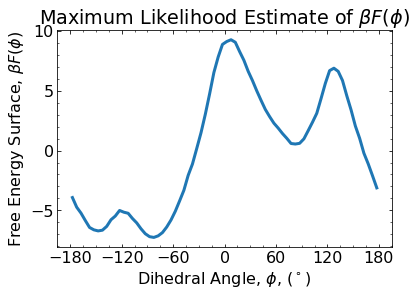

In [46]:
# Plot betaF_MAP vs binCenters (phi)
plt.plot(binC[0], betaF_MAP)
plt.xlabel(r"Dihedral Angle, $\phi$, $(^\circ)$")
plt.xticks(np.arange(-180, 181, 60))
plt.ylabel(r"Free Energy Surface, $\beta F(\phi)$")
plt.title(r"Maximum Likelihood Estimate of $\beta F(\phi)$")
plt.show()

In [47]:
f__betaF_MH = os.path.join("data_out_uniformPrior", "betaF_MH.txt")

betaF_MH = []
with open(f__betaF_MH, "r") as fin:
    for line in fin:
        betaF_MH.append(line.strip().split())
betaF_MH = [[float(y) for y in x] for x in betaF_MH]
betaF_MH = np.array(betaF_MH)

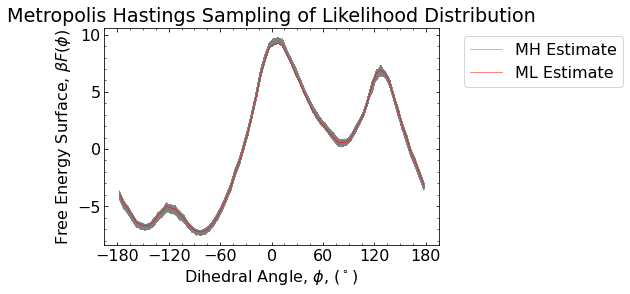

In [139]:
# Plot betaF_MH -> Realizations of the full posterior distribution
nSamples_MH = betaF_MH.shape[0]
for k in range(0,nSamples_MH):
    if k == 0:
        plt.plot(binC[0], betaF_MH[k, :], color="0.5", lw=0.5, label="MH Estimate")
    else:
        plt.plot(binC[0], betaF_MH[k, :], color="0.5", lw=0.5)
plt.plot(binC[0], betaF_MAP, "r", lw=0.5, label="ML Estimate")
plt.xlabel(r"Dihedral Angle, $\phi$, $(^\circ)$")
plt.ylabel(r"Free Energy Surface, $\beta F(\phi)$")
plt.title("Metropolis Hastings Sampling of Likelihood Distribution")
plt.xticks(np.arange(-180, 181, 60))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

In [49]:
# Load log likelihood vs MH step and plot
step_MH = []
f__step_MH = os.path.join("data_out_uniformPrior", "step_MH.txt")
with open(f__step_MH, "r") as fin:
    for line in fin:
        step_MH.append(int(line))
step_MH = np.array(step_MH)

logL_MH = []
f__logL_MH = os.path.join("data_out_uniformPrior", "logL_MH.txt")
with open(f__logL_MH, "r") as fin:
    for line in fin:
        logL_MH.append(float(line))
logL_MH = np.array(logL_MH)

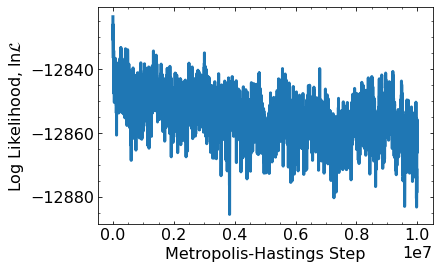

In [50]:
# Plot logL_MH vs step_MH
plt.plot(step_MH, logL_MH)
plt.xlabel("Metropolis-Hastings Step")
plt.ylabel(r"Log Likelihood, $\ln{\mathcal{L}}$")
plt.show()

In order to computer statistics on our Markov Chain of free energy surfaces, we must first discard the burn-in
and compute the correlation length. From the time series plot of the log likelihood, we see oscillation about
a log likelihood of roughly $-12860$ by step $4 \times 10^6$ of our Markov chain, so we set the burn-in time as:
$$
n_{burn} = 4 \times 10^6 \text{ steps}
$$

After discarding the burn-in we can compute the correlation length in two ways. First, we can divide our chain
into many segments of length $n$ steps. We then define the correlation length $n_{corr}$ as the $n$ which
satisfies:

$$
\frac{1}{2}\sigma_c^2 = \langle \sigma_n^2 \rangle
$$

Where $\sigma_c^2$ is the variance of the entire chain and $\langle \sigma_n^2 \rangle$ is the average variance
over the subchains of length $n$. Next, we can estimate the correlation length using the autocorrelation function:

$$
f(x, n) = \frac{1}{N}\sum_{i=1}^N \frac{(x_{i+n} - x_i)^2}{\langle x^2 \rangle - \langle x\rangle^2}
$$

We then take the correlation length to be the $n$ for which $f(x, n) = 1$. With an estimate of the correlation
length, we can store every $n_{corr}^{\text{th}}$ step of our chain resulting in a collection of independent and
identically distributed draws from the posterior distribution for which we can perform statistics (a process known
as chain thinning).

In [259]:
# Discard burn-in
SAVE_MOD_MH = 1e3
STEPS_MH = 1e7
n_burn = .4e7
n_burn_idx = int(n_burn/SAVE_MOD_MH - 1)
step_MH_burned = step_MH[n_burn_idx:]
logL_MH_burned = logL_MH[n_burn_idx:]

# Calculate Correlation length: first by dividing chain into subchains of length n
def find_corr_length(param, n_vals):
    var_subchain_avgs = np.zeros(len(n_vals))
    for i in range(len(n_vals)):
        # Need to split evenly, get remainder of total burned chaiend
        # divided by n, remove this many elements from the front
        remain = len(param) % n_vals[i]
        subchains = np.asarray(np.split(param[remain:], len(param[remain:]) // n_vals[i]))
        subchain_vars = np.var(subchains, axis=1)
        var_subchain_avgs[i] = np.mean(subchain_vars)
    # Find correlation length
    corr_length_idx = (np.abs(var_subchain_avgs - tot_var/2)).argmin()
    return (corr_length_idx, var_subchain_avgs)

n_vals = np.arange(1, len(step_MH_burned))
tot_var = np.var(logL_MH_burned)

# Find correlation length and effective number of points
corr_length_idx, var_subchain_avgs = find_corr_length(logL_MH_burned, n_vals)
corr_length = n_vals[corr_length_idx]*SAVE_MOD_MH
N_eff = (STEPS_MH - n_burn)/corr_length
print("Subchain Variances:")
print("Correlation Length (MCMC Steps):", corr_length)
print("Number of Effective Points:", N_eff)
print("(1/2)Var(Full Chain):", tot_var/2)
print("<Var(Subchains)> at Correlation Length:", var_subchain_avgs[corr_length_idx])

Subchain Variances:
Correlation Length (MCMC Steps): 37000.0
Number of Effective Points: 162.16216216216216
(1/2)Var(Full Chain): 18.335727764752665
<Var(Subchains)> at Correlation Length: 18.32024601177756


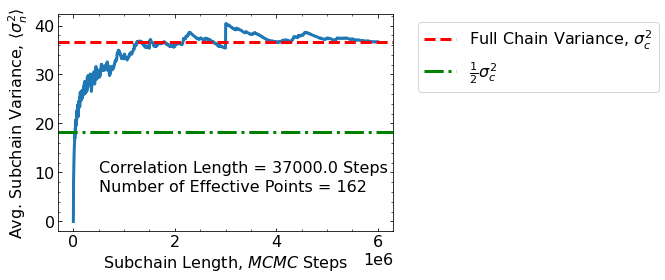

In [263]:
# Subchain variance plot
f, ax = plt.subplots()
ax.plot(n_vals*SAVE_MOD_MH, var_subchain_avgs)
ax.axhline(y=tot_var, color='r', linestyle='--', label=r"Full Chain Variance, $\sigma_c^2$")
ax.axhline(y=tot_var/2, color='g', linestyle='-.', label=r"$\frac{1}{2}\sigma_c^2$")
ax.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
ax.set_xlabel(r"Subchain Length, $MCMC$ Steps")
ax.set_ylabel(r"Avg. Subchain Variance, $\langle \sigma_n^2 \rangle$")
ax.annotate("Correlation Length = {} Steps".format(corr_length), xy=(0.5e6, 10))
ax.annotate("Number of Effective Points = {}".format(int(N_eff)), xy=(0.5e6, 6))
plt.show()

In [265]:
# Determine correlation length using autocorrelation function:
def autocorr(x, n):
    """
    x : np.array
    n : int
    """
    N = len(x)
    tot = 0
    tot_var = np.var(x)
    for i in range(0, N - n):
        tot += (x[i + n] - x[i])**2/tot_var
    result = tot/N
    return result

autocorr_vals = np.zeros(len(n_vals))
for i in range(len(n_vals)):
    autocorr_n = autocorr(logL_MH_burned, n_vals[i])
    autocorr_vals[i] = autocorr_n

In [267]:
# Find n for which f(x, n) = 1
autocorr_len_idx = (np.abs(autocorr_vals - 1)).argmin()
autocorr_len = n_vals[autocorr_len_idx]*SAVE_MOD_MH
autocorr_N_eff = (STEPS_MH - n_burn)/autocorr_len
print("Autocorrelation Function:")
print("Correlation Length", autocorr_len)
print("Number of Effective Points:", autocorr_N_eff)
print("f(x, n_corr):", autocorr_vals[autocorr_len_idx])

Autocorrelation Function:
Correlation Length 2668000.0
Number of Effective Points: 2.2488755622188905
f(x, n_corr): 1.0004080394534873


The correlation length predicted by dividing the chain into many subchains seems reasonable, while that predicted
by the autocorrelation function appears to be too large. This could be due to the fact that we should consider
variances in model parameters rather than variances in the log likelihood itself. For this MCMC analysis, our
model parameters essentially consist of unbiased bin counts of alanine dipeptide configurations having a
particular value of $\phi$ in our discretized coordinates. We could compute the variance of every bin count
over the chain, but it is of greater physical interest to consider the distribution of local minima in our
unbiased FES over our Metropolis Hastings samples, as these correspond to stable polypeptide conformations. We
consider both these measurements of uncertainty in our free energy surface below.

### Uncertainty in Free Energy Landscape

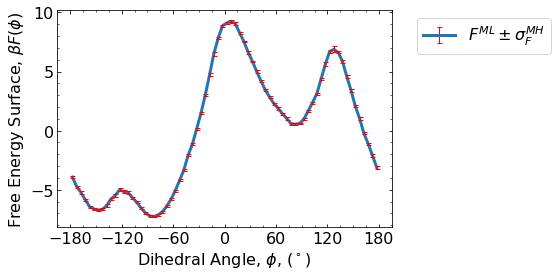

In [143]:
# Plot MAP estimate of F with error bars computed from uncertainties in burned chain
# betaF_MH : rows = MH samples, cols = unbiased bin values of F
# discard burn-in
betaF_MH_burned = betaF_MH[n_burn_idx:][:]

# Compute standard deviations over burned bin counts
betaF_MH_uncert = np.std(betaF_MH_burned, axis=0)
betaF_MH_uncert

plt.errorbar(binC[0], betaF_MAP, yerr=betaF_MH_uncert,
             ecolor="red", barsabove=True, capsize=2.5,
             elinewidth=1, label=r"$F^{ML} \pm \sigma_F^{MH}$")
plt.xlabel(r"Dihedral Angle, $\phi$, $(^\circ)$")
plt.ylabel(r"Free Energy Surface, $\beta F(\phi)$")
plt.xticks(np.arange(-180, 181, 60))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()

### Uncertainty in Minimum Free Energy Diheadrals
We now consider determine the minima of the maximum likelihood predicted free energy surface and the uncertainty
in these parameters from our Metropolis-Hastings sampling of the distribution of surfaces

In [277]:
# Find minima in MAP=ML estimate of FES
minima_MAP_idx = argrelextrema(betaF_MAP, np.less)
stable_phi_MAP = binC[0][minima_MAP_idx[0]]
print("MAP FES:")
print("Minimum FES Phi Angles (degrees):", stable_phi_MAP)
print("")
# Repeat for burned MH estimates -> uncertainty in stable phi angles
n_MH_burned = betaF_MH_burned.shape[0]
stable_phi_MH = np.zeros((n_MH_burned, len(stable_phi_MAP)))
for i in range(n_MH_burned):
    minima_idx = argrelextrema(betaF_MH_burned[i, :], np.less)
    if minima_idx[0].shape[0] > 3:
        betaF_MH_vals = betaF_MH_burned[i, minima_idx[0]]
        phi_vals = binC[0][minima_idx[0]]
        if i % 1000 == 0:
            print("MH Step:", (i+1)*SAVE_MOD_MH)
            print("Min Idx:", minima_idx[0])
            print("betaF:", betaF_MH_vals)
            print("Phi:", phi_vals)
            print("")

MAP FES:
Minimum FES Phi Angles (degrees): [-147.5  -82.5   82.5]

MH Step: 1000.0
Min Idx: [ 7 12 19 53]
betaF: [-6.7891   -5.28053  -7.29127   0.441202]
Phi: [-142.5 -117.5  -82.5   87.5]

MH Step: 1001000.0
Min Idx: [ 6 12 19 52]
betaF: [-6.76188  -5.33085  -7.27602   0.462881]
Phi: [-147.5 -117.5  -82.5   82.5]

MH Step: 2001000.0
Min Idx: [ 6 12 19 52]
betaF: [-6.93835  -5.29419  -7.25002   0.536444]
Phi: [-147.5 -117.5  -82.5   82.5]

MH Step: 4001000.0
Min Idx: [ 6 18 52 61]
betaF: [-6.94737 -7.35999  0.57241  6.50638]
Phi: [-147.5  -87.5   82.5  127.5]

MH Step: 5001000.0
Min Idx: [ 6 19 51 53]
betaF: [-6.81003  -7.21071   0.543831  0.562248]
Phi: [-147.5  -82.5   77.5   87.5]

MH Step: 6001000.0
Min Idx: [ 6 18 20 51]
betaF: [-6.94644  -7.24036  -7.23757   0.535166]
Phi: [-147.5  -87.5  -77.5   77.5]

MH Step: 8001000.0
Min Idx: [ 6 19 37 52]
betaF: [-6.81534  -7.42788   9.41513   0.564285]
Phi: [-147.5  -82.5    7.5   82.5]

MH Step: 9001000.0
Min Idx: [ 6 19 37 51 53]
betaF:

We see that `scipy.signal.argrelextrema` is returning more than three stable dihedral $\phi$ angles for some of
the Metropolis-Hastings sampled free energy landscapes. This does not seem reasonable given the initial of the
sampled landscapes, and so we formulate our own minimization routine by searching over an initial guesses ranges
of $\phi$ centered around the expected stable angles.

In [278]:
def find_betaF_min(phi, betaF, ig=[-147.5, -82.5, 82.5], search_range=[30, 30, 30]):
    # Check input
    if len(ig) != len(search_range):
        raise ValueError("Initial Phi Angle Guess and Search Ranges Must have same length")
    min_angles = []
    for i in range(len(ig)):
        guess_idx = np.where(phi == ig[i])[0][0]
        upper_idx = np.abs(phi - (ig[i] + search_range[i]/2)).argmin()
        lower_idx = np.abs(phi - (ig[i] - search_range[i]/2)).argmin()
        betaF_search = betaF[lower_idx: upper_idx]
        min_idx = np.argmin(betaF_search) + lower_idx
        min_angles.append(phi[min_idx])    
    return min_angles
print("Consistency Check for MAP Estimate:")
print("Minimum FES Phi Angles (degrees):", find_betaF_min(binC[0], betaF_MAP))

Consistency Check for MAP Estimate:
Minimum FES Phi Angles (degrees): [-147.5, -82.5, 82.5]


In [283]:
# Apply find_betaF_min to MH chain
stable_phi_MH_burned = np.zeros((n_MH_burned, len(stable_phi_MAP)))
for i in range(n_MH_burned):
    stable_phi_MH_burned[i, :] = find_betaF_min(binC[0], betaF_MH_burned[i, :])

# Find standard deviation in minimum energy phi dihedrals
uncert_phi = np.std(stable_phi_MH_burned, axis=0)

# Report MAP +/- sigma_MH Estimate
print("Stable Dihedral Phi Angles:")
print("(Maximum Likelihood Estimate) +/- (Standard Deviation Metropolis-Hastings Samples)")
for i in range(len(stable_phi_MAP)):
    print("(%s +/- %s) degrees" % (stable_phi_MAP[i], uncert_phi[i]))

Stable Dihedral Phi Angles:
(Maximum Likelihood Estimate) +/- (Standard Deviation Metropolis-Hastings Samples)
(-147.5 +/- 2.4046251729162993) degrees
(-82.5 +/- 2.2193435605699996) degrees
(82.5 +/- 3.006421034563499) degrees


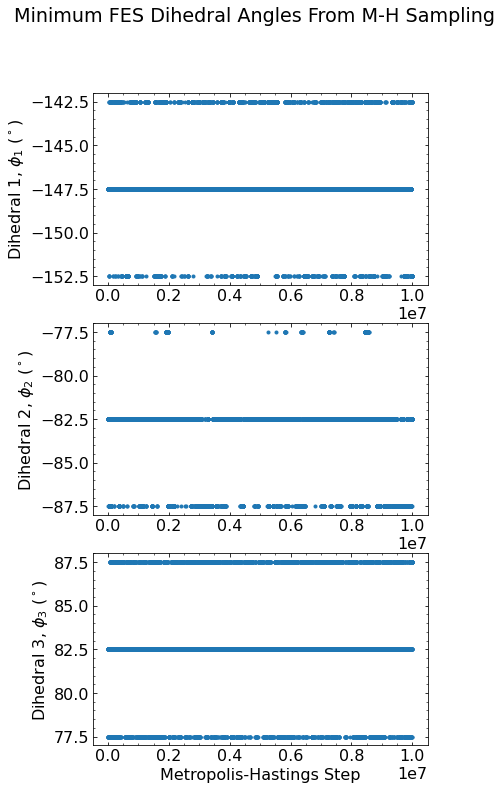

In [316]:
# Plot progression of minimum phi angles over all MH samples
stable_phi_MH = np.zeros((len(step_MH), 3))
for i in range(len(step_MH)):
    stable_phi_MH[i, :] = find_betaF_min(binC[0], betaF_MH[i, :])

f, axes = plt.subplots(3, figsize=(6, 12))
for i in range(stable_phi_MH.shape[1]):
    axes[i].plot(step_MH, stable_phi_MH[:, i], '.')
    axes[i].set_ylabel(r"Dihedral {x}, $\phi_{x}$ $(^\circ)$".format(x=str(i+1)))
axes[2].set_xlabel(r"Metropolis-Hastings Step")
f.suptitle("Minimum FES Dihedral Angles From M-H Sampling")
plt.show()

We have thus found that over the course of the MCMC sampling, each stable dihedral $\phi$ angle determined from
the local minima of the posterior distribution-realized free energy surfaces oscillate between three values, each
separated by $5^\circ$ from the maximum likelihood FES predicted angle. This is simply the bin spacing of our
order paramter $\phi$, indicating that over the course of the random walk the FES shifts the equilibrium dihedral
angles by at most plus or minus one bin. Ferguson highlights in his work that "estimations of the unbiased FES are
gnerally elatively robust over a range of bin choices" (Ferguson 1587). he bin size does however introduce bias
due o the fact that it decreases our model complexity (larger bins means less coordinates in our distribution),
which hould increase the variance of our results due to the bias-variance tradeoff. It would therefore be
worthwhile to investigate the effect of varying bin size on these results.

## References:
Ferguson, A.L., "BayesWHAM: A Bayesian approach for free energy estimation, reweighting, and uncertainty quantification in the weighted histogram analysis method" J. Comput. Chem. 38 18 1583-1605 (2017). DOI: 10.1002/jcc.24800

Mironov, V., Alexeev, Y., Mulligan, V. K., Fedorov, D. G., "A systematic study of minima in alanine dipeptide" J. Comput. Chem. 40 297–309 (2019). DOI: 10.1002/jcc.25589

In [320]:
print(82.5-77.5)
print(87.5-82.5)
print(-82.5-(-87.5))
print(-77.5-(-82.5))
print(-142.5 - (-147.5))
print(-147.5-(-152.5))

5.0
5.0
5.0
5.0
5.0
5.0


In [157]:
60/4

15.0

In [105]:
test = np.asarray([[1,2,3],
                   [4,5,6],
                   [7,8,9]])
test

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [111]:
test2 = test[1:][:]

In [112]:
test2

array([[4, 5, 6],
       [7, 8, 9]])

In [169]:
test[1, :] = [1, 1, 1]
test

array([[1, 2, 3],
       [1, 1, 1],
       [7, 8, 9]])

In [115]:
np.std([5, 8])

1.5

In [70]:
3.5e6/10000

350.0

In [71]:
step_MH[350]

351000